# References

This notebook contains analysis of certificate references in Common Criteria certificates.

In [2]:
import warnings
from pathlib import Path
from typing import Iterable

import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import seaborn as sns
from notebooks.fixed_sankey_plot import sankey
from tqdm import tqdm

from sec_certs.dataset.cc import CCDataset

# Surpress user warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

# matplotlib.use("pgf")
sns.set_theme(style="white")
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["legend.fontsize"] = 6.5
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["ytick.left"] = True
plt.rcParams["ytick.major.size"] = 5
plt.rcParams["ytick.major.width"] = 0.5
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["xtick.bottom"] = True
plt.rcParams["xtick.major.size"] = 5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["xtick.major.pad"] = 0
# plt.rcParams["pgf.texsystem"] = "pdflatex"
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["text.usetex"] = True
# plt.rcParams["pgf.rcfonts"] = False
plt.rcParams["axes.titlesize"] = 8
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams["lines.markersize"] = 4
plt.rcParams["savefig.pad_inches"] = 0.01
sns.set_palette("deep")

# plt.style.use("seaborn-whitegrid")
# sns.set_palette("deep")
# sns.set_context("notebook")  # Set to "paper" for use in paper :)

# plt.rcParams['figure.figsize'] = (10, 6)

RESULTS_DIR = Path("./results/references")
RESULTS_DIR.mkdir(exist_ok=True, parents=True)
SMARTCARD_CATEGORY = "ICs, Smart Cards and Smart Card-Related Devices and Systems"


## Common processing functions

In [61]:
def len_if_exists(x) -> int:
    return len(x) if pd.notnull(x) else 0


def compute_reference_numbers(df__: pd.DataFrame) -> pd.DataFrame:
    """
    Creates new columns with number of references for each certificate.
    """
    return df__.copy().assign(
        n_refs=lambda df_: df_.refs.map(len_if_exists),
        n_trans_refs=lambda df_: df_.trans_refs.map(len_if_exists),
        n_in_refs=lambda df_: df_.in_refs.map(len_if_exists),
        n_in_trans_refs=lambda df_: df_.in_trans_refs.map(len_if_exists),
    )


def preprocess_cc_df(cc_df: pd.DataFrame) -> pd.DataFrame:
    """
    Pre-processing run on the CC dataset for the sake of this notebook.
    """
    return (
        cc_df.loc[cc_df.cert_id.notnull()]
        .copy()
        .rename(
            columns={
                "directly_referencing": "refs",
                "indirectly_referencing": "trans_refs",
                "directly_referenced_by": "in_refs",
                "indirectly_referenced_by": "in_trans_refs",
            }
        )
        .assign(
            longer_than_5_years=lambda df_: df_.not_valid_after - df_.not_valid_before > pd.Timedelta(days=5 * 365),
            not_valid_after=lambda df_: df_.not_valid_after.where(
                ~df_.longer_than_5_years, df_.not_valid_before + pd.Timedelta(days=5 * 365)
            ),
        )
        .drop_duplicates(subset=["cert_id"], keep="first")  # TODO: Investigate high number of duplicates and resolve
    )


def compute_references(cc_df: pd.DataFrame, graph: nx.DiGraph, label: str | Iterable[str]) -> pd.DataFrame:
    """
    Limits the columns with references to a given label.
    """
    label = label if isinstance(label, Iterable) else [label]
    sub_edges = [(u, v) for u, v, d in graph.edges(data=True) if d.get("reference_label") in label]
    subgraph = graph.edge_subgraph(sub_edges)

    return cc_df.assign(
        refs=lambda df_: df_.apply(
            lambda row: set(subgraph.successors(row.cert_id)) if row.cert_id in subgraph else np.nan,
            axis=1,
        ),
        trans_refs=lambda df_: df_.apply(
            lambda row: set(nx.descendants(subgraph, row.cert_id)) if row.cert_id in subgraph else np.nan, axis=1
        ),
        in_refs=lambda df_: df_.apply(
            lambda row: set(subgraph.predecessors(row.cert_id)) if row.cert_id in subgraph else np.nan,
            axis=1,
        ),
        in_trans_refs=lambda df_: df_.apply(
            lambda row: set(nx.ancestors(subgraph, row.cert_id)) if row.cert_id in subgraph else np.nan, axis=1
        ),
    )


def preprocess_refs_df(csv_path: str | Path, cc_df: pd.DataFrame) -> pd.DataFrame:
    return (
        pd.read_csv(csv_path)
        .pipe(lambda df_: df_.loc[df_.dgst.isin(cc_df.index)])
        .assign(cert_id=lambda df_: df_.dgst.map(cc_df.cert_id.to_dict()))
    )


def get_reference_graph_from_refs_df(refs_df: pd.DataFrame) -> nx.DiGraph:
    return nx.from_pandas_edgelist(
        refs_df,
        source="cert_id",
        target="reference",
        create_using=nx.DiGraph,
        edge_attr=["reference_label"],
    )


## Load data and compute reference graph

In [68]:
dset = CCDataset.from_json("/Users/adam/phd/projects/certificates/sec-certs/dataset/cc_final_run_may_23/dataset.json")
cc_df = preprocess_cc_df(dset.to_pandas())
refs_df = preprocess_refs_df("/Users/adam/Downloads/predictions.csv", cc_df)
unique_labels = refs_df.reference_label.unique().tolist()

# Load labeled reference graph as networkx directed graph
graph = nx.from_pandas_edgelist(
    refs_df,
    source="cert_id",
    target="canonical_reference_keyword",
    edge_attr="reference_label",
    create_using=nx.DiGraph,
)

cc_df = compute_reference_numbers(compute_references(cc_df, graph, unique_labels))


## Common processing functions

In [ ]:
# Understand which columns I need and limit myself to those columns
# Every analytical cell should be isolated in a function that takes a single input: The dataframe of certificates to work on.
#     - The number of those references is computed in the function itself
#     - Each analytical method should have some tests at the end
#     - If some LaTeX output accompanies the computaiton, the function should return it as a string
#     - Those are stored in a dictionary that keeps expanding


### Count numbers of reference-rich certificates

Number of smartcard certificates that reference some other certificate: 1205 (72.11%)
Number of non-smartcard certificates that reference some other certificate: 333 (9.43%)
Total number of referencing certificates: 1538 (29.57%)


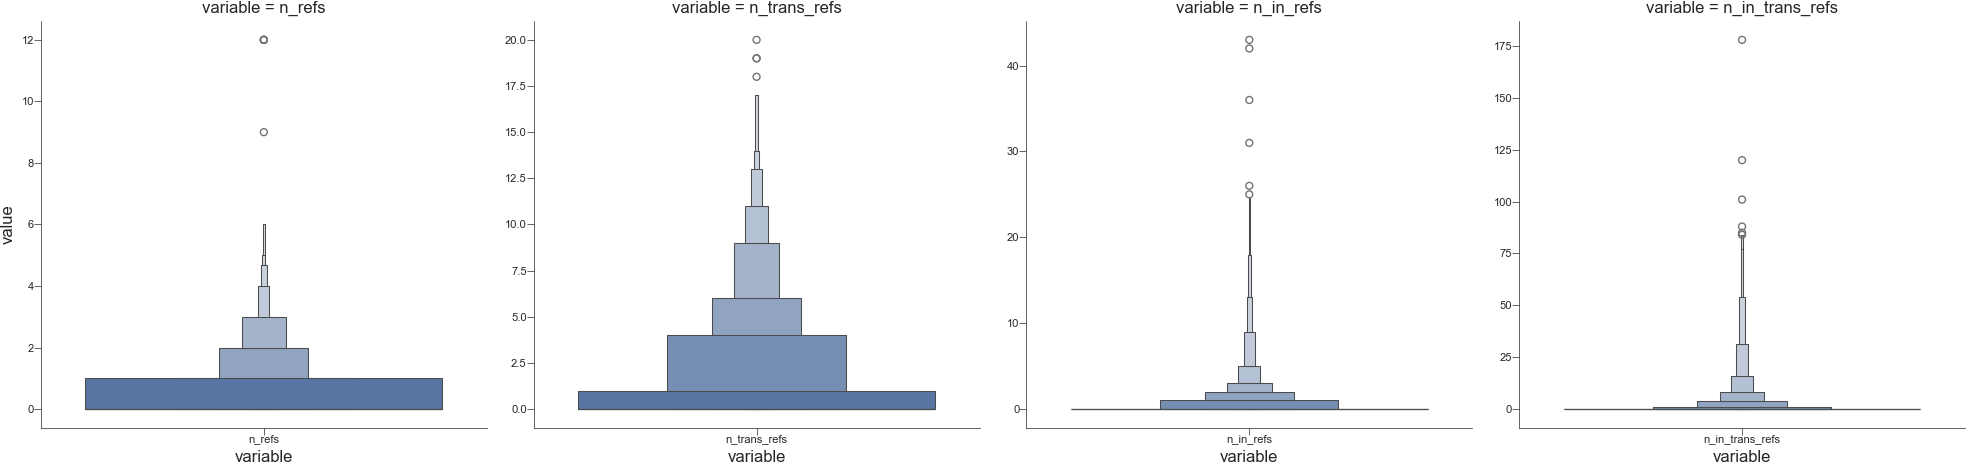

{}

In [64]:
def compute_basic_reference_graph_stats(df__: pd.DataFrame, graph: nx.DiGraph) -> dict[str, str]:
    df = df__.copy().assign(has_refs=lambda df_: df_.refs.notnull()).pipe(compute_reference_numbers)

    n_ref_smartcards = df.loc[(df.has_refs) & (df.category == SMARTCARD_CATEGORY)].shape[0]
    n_ref_others = df.loc[(df.has_refs) & (df.category != SMARTCARD_CATEGORY)].shape[0]

    print(
        f"Number of smartcard certificates that reference some other certificate: {n_ref_smartcards} ({100 * n_ref_smartcards / df.loc[df.category == SMARTCARD_CATEGORY].shape[0]:.2f}%)"
    )
    print(
        f"Number of non-smartcard certificates that reference some other certificate: {n_ref_others} ({100 * n_ref_others / df.loc[df.category != SMARTCARD_CATEGORY].shape[0]:.2f}%)"
    )
    print(
        f"Total number of referencing certificates: {n_ref_smartcards + n_ref_others} ({100 * (n_ref_smartcards + n_ref_others) / df.shape[0]:.2f}%)"
    )

    df_melted = df[["n_refs", "n_trans_refs", "n_in_refs", "n_in_trans_refs"]].melt()
    df_melted["incoming"] = df_melted.variable.map(lambda x: bool(x.endswith("by")))
    sns.catplot(data=df_melted, kind="boxen", x="variable", y="value", col="variable", sharex=False, sharey=False)
    plt.savefig(RESULTS_DIR / "boxen_plot_references.pdf", bbox_inches="tight")

    plt.show()

    return {}


compute_basic_reference_graph_stats(cc_df, graph)


## Evolution of certificate reach for top-10 certificates

                                  cert_id  n_in_trans_refs
dgst                                                      
2d835bff00514238  BSI-DSZ-CC-0891-V2-2016                9
9664c0f0ec6401b9  BSI-DSZ-CC-0891-V3-2018                5
b5b8de155e4e40e6         ANSSI-CC-2016/44                4
9dab3f1341f54c42     BSI-DSZ-CC-0555-2009                4
f041e5b526e79ef4     BSI-DSZ-CC-0410-2007                4
dd000f356b48904d     BSI-DSZ-CC-0813-2012                3
5e06be752f7bf01a     BSI-DSZ-CC-0404-2007                3
77acb3a4a3f58e0b         ANSSI-CC-2015/80                3
dfc0e5c6e48f7c5a  BSI-DSZ-CC-0837-V2-2014                3
981f7ea91d7bdcb6         ANSSI-CC-2014/86                3























  0%|          | 0/10 [06:37<?, ?it/s]












100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


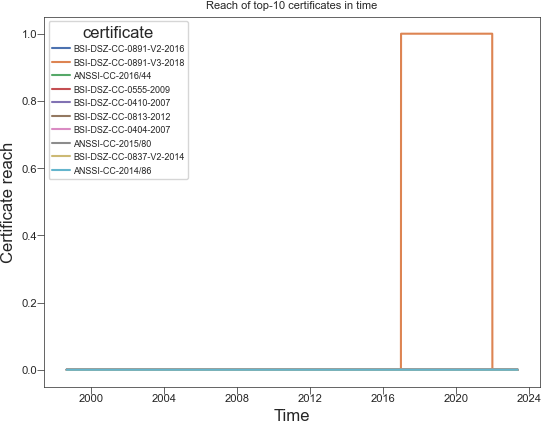

{}

In [89]:
# TODO: Check that it actually works, the data on small subset was fairly weird
# TODO: Work only on sub-component references?
def compute_certs_top_reach(df__: pd.DataFrame) -> dict:
    def find_reach_over_time(df_: pd.DataFrame, cert_id: str, date_range: pd.DatetimeIndex) -> pd.Series:
        df = df_.copy().loc[lambda df_: df_.in_trans_refs.apply(lambda x: pd.notnull(x) and cert_id in x)]
        dct = {
            date: df.loc[(date >= df.not_valid_before) & (date <= df.not_valid_after)].shape[0] for date in date_range
        }
        return pd.Series(dct, name=cert_id)

    df = df__.copy()
    top_10_certs = df.sort_values(by="n_in_trans_refs", ascending=False).head(10)
    print(top_10_certs[["cert_id", "n_in_trans_refs"]])

    date_range = pd.date_range(df.not_valid_before.min(), df.not_valid_before.max())
    data = [find_reach_over_time(df, x, date_range) for x in tqdm(top_10_certs.cert_id.tolist())]
    df_reach_evolution_melted = (
        pd.concat(data, axis=1)
        .rename_axis("date")
        .reset_index()
        .melt(id_vars="date", var_name="certificate", value_name="reach")
    )

    g = sns.lineplot(data=df_reach_evolution_melted, x="date", y="reach", hue="certificate")
    g.set(title="Reach of top-10 certificates in time", xlabel="Time", ylabel="Certificate reach")
    plt.savefig(RESULTS_DIR / "lineplot_top_certificate_reach.pdf", bbox_inches="tight")
    plt.show()

    return {}


compute_certs_top_reach(cc_df)


## Average number of references & certificate reach over time

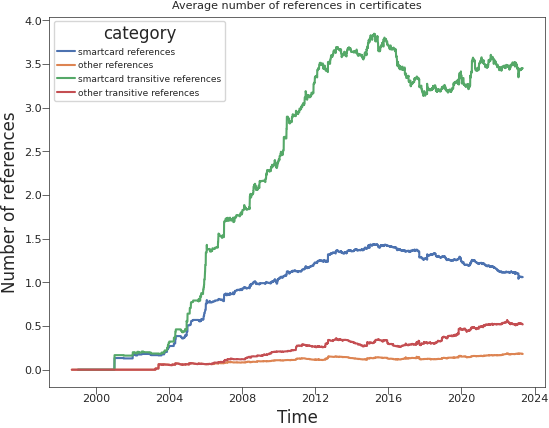

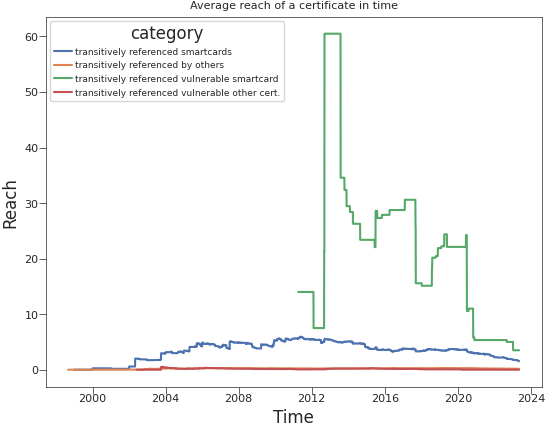

In [9]:
def compute_avg_references(df: pd.DataFrame, smartcards: bool, variable: str, date_range: pd.DateTimeIndex) -> dict:
    """
    Computes a dictionary (from which series can be created) where index is date and value is average 'variable' value
    for certificates that were valid at that time, coming from either smardcards or other categories.
    E.g., variable can be `directly_referencing`.
    """
    df_copy = df.copy()
    df_copy["target_variable"] = df[variable].map(lambda x: len(x) if pd.notnull(x) else 0)

    dct = {}
    for date in date_range:
        if smartcards:
            dct[date] = df_copy.loc[
                (date >= df_copy.not_valid_before)
                & (date <= df_copy.not_valid_after)
                & (df_copy.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
            ]["target_variable"].mean()
        else:
            dct[date] = df_copy.loc[
                (date >= df_copy.not_valid_before)
                & (date <= df_copy.not_valid_after)
                & (df_copy.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
            ]["target_variable"].mean()
    return dct


date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())

refs_smartcards = compute_avg_references(df_id_rich, True, "directly_referencing", date_range)
trans_refs_smartcards = compute_avg_references(df_id_rich, True, "indirectly_referencing", date_range)
refs_others = compute_avg_references(df_id_rich, False, "directly_referencing", date_range)
trans_refs_others = compute_avg_references(df_id_rich, False, "indirectly_referencing", date_range)
df_avg_num_refs = pd.concat(
    [
        pd.Series(refs_smartcards, name="smartcard references"),
        pd.Series(refs_others, name="other references"),
        pd.Series(trans_refs_smartcards, name="smartcard transitive references"),
        pd.Series(trans_refs_others, name="other transitive references"),
    ],
    axis=1,
)
df_avg_num_refs.index.name = "date"
df_avg_num_refs = df_avg_num_refs.reset_index()
df_avg_num_refs_melted = df_avg_num_refs.melt(id_vars=["date"], var_name="category", value_name="n_references")

reach_smartcards = compute_avg_references(df_id_rich, True, "indirectly_referenced_by", date_range)
reach_others = compute_avg_references(df_id_rich, False, "indirectly_referenced_by", date_range)

df_vulnerable = df_id_rich.loc[df_id_rich.related_cves.notnull()]
reach_vuln_smartcards = compute_avg_references(df_vulnerable, True, "indirectly_referenced_by", date_range)
reach_vuln_others = compute_avg_references(df_vulnerable, False, "indirectly_referenced_by", date_range)

df_avg_reach = pd.concat(
    [
        pd.Series(reach_smartcards, name="transitively referenced smartcards"),
        pd.Series(reach_others, name="transitively referenced by others"),
        pd.Series(reach_vuln_smartcards, name="transitively referenced vulnerable smartcard"),
        pd.Series(reach_vuln_others, name="transitively referenced vulnerable other cert."),
    ],
    axis=1,
)
df_avg_reach.index.name = "date"
df_avg_reach = df_avg_reach.reset_index()
df_avg_reach_melted = df_avg_reach.melt(id_vars=["date"], var_name="category", value_name="certificate reach")

g = sns.lineplot(data=df_avg_num_refs_melted, x="date", y="n_references", hue="category")
g.set(title="Average number of references in certificates", xlabel="Time", ylabel="Number of references")
plt.savefig(RESULTS_DIR / "lineplot_avg_n_references.pdf", bbox_inches="tight")
plt.show()

g = sns.lineplot(data=df_avg_reach_melted, x="date", y="certificate reach", hue="category", errorbar=None)
g.set(title="Average reach of a certificate in time", xlabel="Time", ylabel="Reach")
plt.savefig(RESULTS_DIR / "lineplot_avg_reach.pdf", bbox_inches="tight")
plt.show()


## Number of active vs. number of reference-rich certificates in time

100%|██████████| 9018/9018 [01:26<00:00, 104.17it/s]


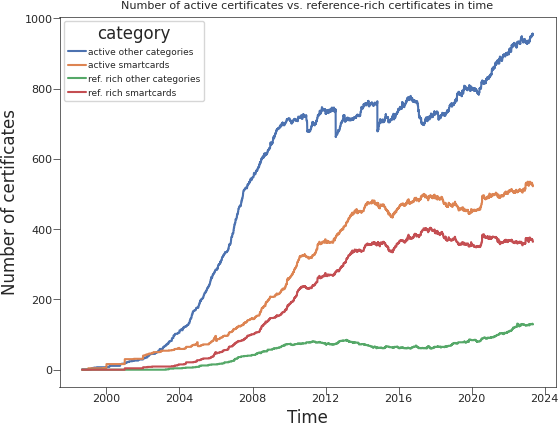

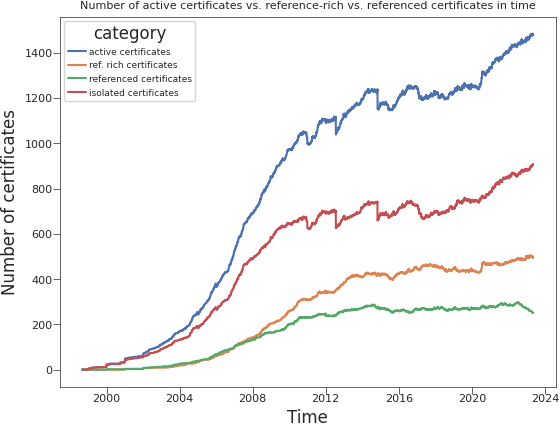

In [10]:
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
dct_active_all = {}
dct_reference_rich_all = {}
dct_referenced_all = {}
dct_isolated_all = {}
dct_active_others = {}
dct_reference_rich_others = {}
dct_active_smartcards = {}
dct_reference_rich_smartcards = {}
for date in tqdm(date_range):
    active_certs = df_id_rich.loc[(date >= df_id_rich.not_valid_before) & (date <= df_id_rich.not_valid_after)]
    dct_active_all[date] = active_certs.shape[0]
    dct_isolated_all[date] = active_certs.loc[
        (active_certs.n_references == 0) & (active_certs.n_referenced_by == 0)
    ].shape[0]
    dct_active_others[date] = active_certs.loc[
        active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems"
    ].shape[0]
    dct_active_smartcards[date] = active_certs.loc[
        active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems"
    ].shape[0]
    dct_reference_rich_all[date] = active_certs.loc[active_certs.n_references > 0].shape[0]
    dct_referenced_all[date] = active_certs.loc[active_certs.n_referenced_by > 0].shape[0]
    dct_reference_rich_others[date] = active_certs.loc[
        (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
        & (active_certs.n_references > 0)
    ].shape[0]
    dct_reference_rich_smartcards[date] = active_certs.loc[
        (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
        & (active_certs.n_references > 0)
    ].shape[0]

df_active_vs_ref_rich = pd.concat(
    [
        pd.Series(dct_active_others, name="active other categories"),
        pd.Series(dct_active_smartcards, name="active smartcards"),
        pd.Series(dct_reference_rich_others, name="ref. rich other categories"),
        pd.Series(dct_reference_rich_smartcards, name="ref. rich smartcards"),
    ],
    axis=1,
)

df_active_vs_ref_rich.index.name = "date"
df_active_vs_ref_rich = df_active_vs_ref_rich.reset_index()

df_active_vs_ref_rich_melted = df_active_vs_ref_rich.melt(
    id_vars=["date"], var_name="category", value_name="number of certificates"
)
g = sns.lineplot(data=df_active_vs_ref_rich_melted, x="date", y="number of certificates", hue="category")
g.set(
    title="Number of active certificates vs. reference-rich certificates in time",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lienplot_n_active_certs_vs_n_references.pdf", bbox_inches="tight")
plt.show()


df_summary_references = pd.concat(
    [
        pd.Series(dct_active_all, name="active certificates"),
        pd.Series(dct_reference_rich_all, name="ref. rich certificates"),
        pd.Series(dct_referenced_all, name="referenced certificates"),
        pd.Series(dct_isolated_all, name="isolated certificates"),
    ],
    axis=1,
)
df_summary_references.index.name = "date"
df_summary_references = df_summary_references.reset_index()
df_summary_references_melted = df_summary_references.melt(
    id_vars=["date"], var_name="category", value_name="number of certificates"
)

g = sns.lineplot(data=df_summary_references_melted, x="date", y="number of certificates", hue="category", errorbar=None)
g.set(
    title="Number of active certificates vs. reference-rich vs. referenced certificates in time",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lineplot_references_summary.pdf", bbox_inches="tight")
plt.show()


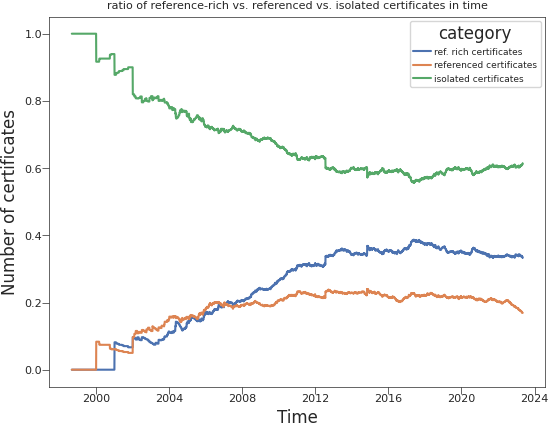

In [11]:
df_ratios = df_summary_references.copy()
df_ratios["ref. rich certificates"] = df_ratios["ref. rich certificates"] / df_ratios["active certificates"]
df_ratios["referenced certificates"] = df_ratios["referenced certificates"] / df_ratios["active certificates"]
df_ratios["isolated certificates"] = df_ratios["isolated certificates"] / df_ratios["active certificates"]
df_ratios = df_ratios.drop(columns=["active certificates"])
df_ratios_melted = df_ratios.melt(id_vars=["date"], var_name="category", value_name="ratio of certificates")

g = sns.lineplot(data=df_ratios_melted, x="date", y="ratio of certificates", hue="category", errorbar=None)
g.set(
    title="ratio of reference-rich vs. referenced vs. isolated certificates in time",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lineplot_reference_ratio.pdf", bbox_inches="tight")
plt.show()


## Number of active certificates that reference some archived certificate in time

100%|██████████| 9018/9018 [02:22<00:00, 63.49it/s] 


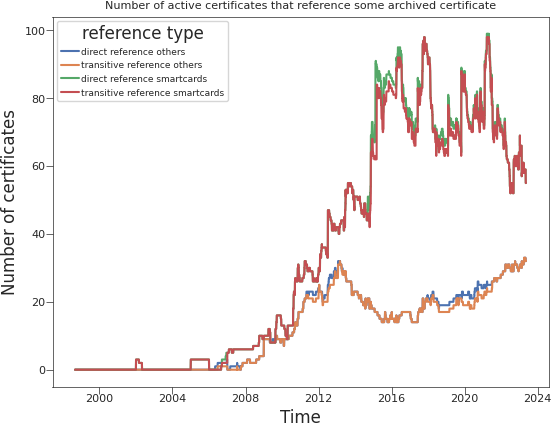

In [12]:
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
dct_direct_others = {}
dct_direct_smartcards = {}
dct_transitive_others = {}
dct_transitive_smartcards = {}
for date in tqdm(date_range):
    active_certs = df_id_rich.loc[(date >= df_id_rich.not_valid_before) & (date <= df_id_rich.not_valid_after)].copy()
    active_certs_cert_ids = set(active_certs["cert_id"].tolist())
    active_certs["no_intersection"] = active_certs.directly_referencing.map(
        lambda x: False if pd.isnull(x) else not x.intersection(active_certs_cert_ids)
    )
    active_certs["no_transitive_intersection"] = active_certs.indirectly_referencing.map(
        lambda x: False if pd.isnull(x) else not x.intersection(active_certs_cert_ids)
    )
    dct_direct_others[date] = active_certs.loc[
        (active_certs.no_intersection)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_others[date] = active_certs.loc[
        (active_certs.no_transitive_intersection)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_direct_smartcards[date] = active_certs.loc[
        (active_certs.no_intersection)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_smartcards[date] = active_certs.loc[
        (active_certs.no_transitive_intersection)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]

df_refs_to_archived = pd.concat(
    [
        pd.Series(dct_direct_others, name="direct reference others"),
        pd.Series(dct_transitive_others, name="transitive reference others"),
        pd.Series(dct_direct_smartcards, name="direct reference smartcards"),
        pd.Series(dct_transitive_smartcards, name="transitive reference smartcards"),
    ],
    axis=1,
)
df_refs_to_archived.index.name = "date"
df_refs_to_archived = df_refs_to_archived.reset_index()
df_refs_to_archived_melted = df_refs_to_archived.melt(
    id_vars=["date"], var_name="reference type", value_name="number of certificates"
)

g = sns.lineplot(data=df_refs_to_archived_melted, x="date", y="number of certificates", hue="reference type")
g.set(
    title="Number of active certificates that reference some archived certificate",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lienplot_active_certs_referencing_archived.pdf", bbox_inches="tight")
plt.show()

# TODO: This analytical function should return command displaying current state of affairs: up-to-date number of now active certs that reference some archived one


## Certificates referencing vulnerable certificates in time

100%|██████████| 9018/9018 [02:19<00:00, 64.54it/s] 


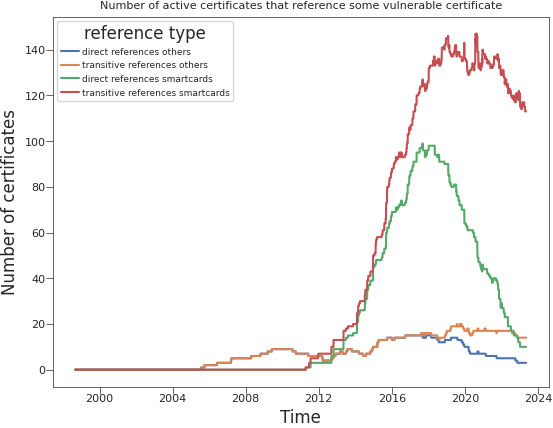

In [13]:
date_range = pd.date_range(df_id_rich.not_valid_before.min(), df_id_rich.not_valid_before.max())
vulnerable_cert_ids = set(df_id_rich.loc[df_id_rich.related_cves.notnull()].cert_id.tolist())
dct_direct_others = {}
dct_transitive_others = {}
dct_direct_smartcards = {}
dct_transitive_smartcards = {}
for date in tqdm(date_range):
    active_certs = df_id_rich.loc[(date >= df_id_rich.not_valid_before) & (date <= df_id_rich.not_valid_after)].copy()
    active_certs["directly_references_vulnerable_cert"] = active_certs.directly_referencing.map(
        lambda x: False if pd.isnull(x) else bool(x.intersection(vulnerable_cert_ids))
    )
    active_certs["transitively_references_vulnerable_cert"] = active_certs.indirectly_referencing.map(
        lambda x: False if pd.isnull(x) else bool(x.intersection(vulnerable_cert_ids))
    )
    dct_direct_others[date] = active_certs.loc[
        (active_certs.directly_references_vulnerable_cert)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_others[date] = active_certs.loc[
        (active_certs.transitively_references_vulnerable_cert)
        & (active_certs.category != "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_direct_smartcards[date] = active_certs.loc[
        (active_certs.directly_references_vulnerable_cert)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]
    dct_transitive_smartcards[date] = active_certs.loc[
        (active_certs.transitively_references_vulnerable_cert)
        & (active_certs.category == "ICs, Smart Cards and Smart Card-Related Devices and Systems")
    ].shape[0]

df_references_vuln = pd.concat(
    [
        pd.Series(dct_direct_others, name="direct references others"),
        pd.Series(dct_transitive_others, name="transitive references others"),
        pd.Series(dct_direct_smartcards, name="direct references smartcards"),
        pd.Series(dct_transitive_smartcards, name="transitive references smartcards"),
    ],
    axis=1,
)
df_references_vuln.index.name = "date"
df_references_vuln = df_references_vuln.reset_index()
df_references_vuln_melted = df_references_vuln.melt(
    id_vars="date", var_name="reference type", value_name="number of certificates"
)

g = sns.lineplot(data=df_references_vuln_melted, x="date", y="number of certificates", hue="reference type")
g.set(
    title="Number of active certificates that reference some vulnerable certificate",
    xlabel="Time",
    ylabel="Number of certificates",
)
plt.savefig(RESULTS_DIR / "lienplot_active_certs_referencing_vulnerable.pdf", bbox_inches="tight")
plt.show()


### Plot direct references per category (count plot)

In [16]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(16, 10)
figure.set_tight_layout(True)

col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x="category", hue=col, ax=axes[index])
    countplot.set(
        xlabel="Category",
        ylabel="Outgoing direct references",
        title=f"Countplot of {' '.join(col.split('_'))}",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(title=" ".join(col.split("_")), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.savefig(str(RESULTS_DIR / "references_countplot.pdf"), bbox_inches="tight")
plt.close(figure)


### Plot direct references per category (Sankey diagram)

AttributeError: 'LatexManager' object has no attribute 'latex'

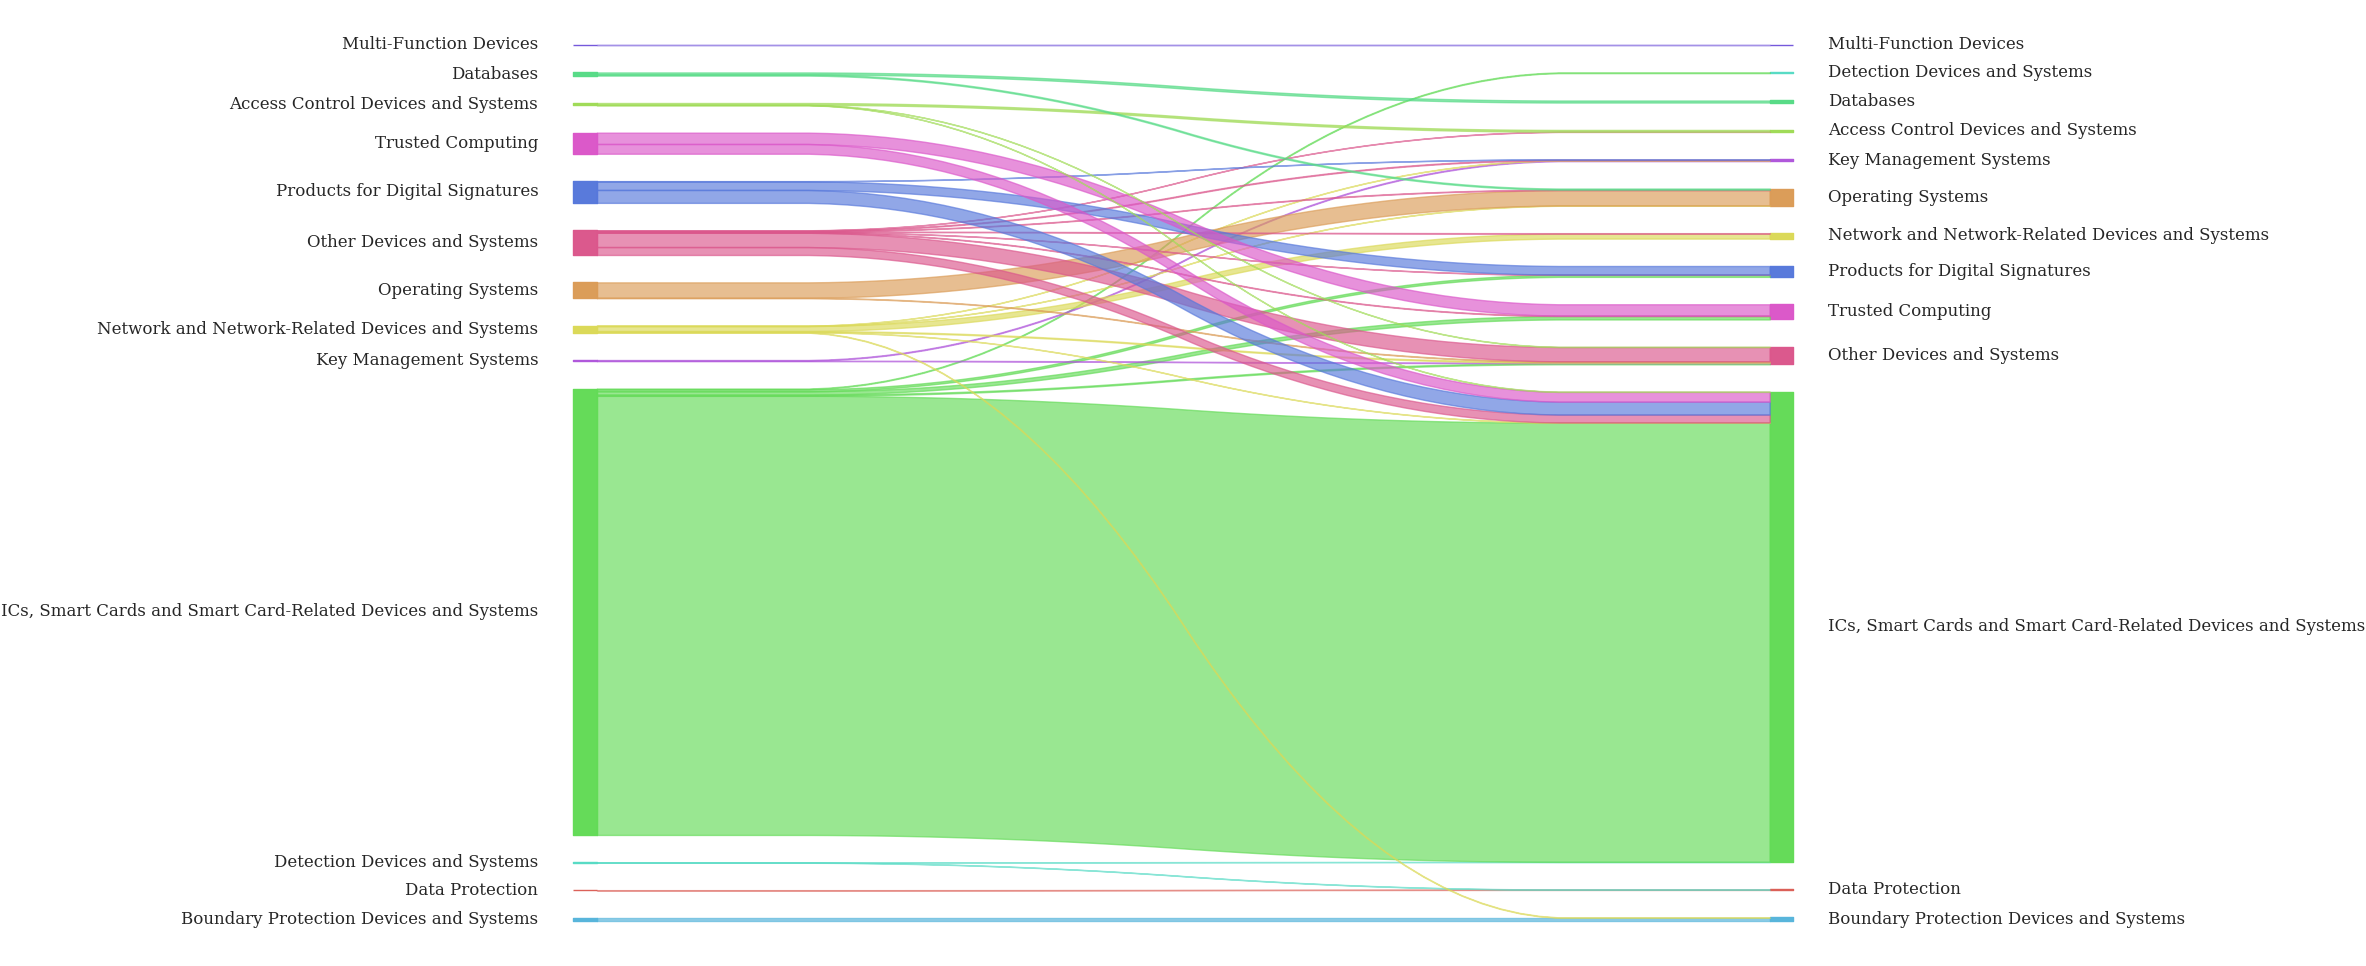

In [15]:
cert_id_to_category_mapping = dict(zip(df.cert_id, df.category))
cert_id_to_category_mapping[np.NaN] = "No references"

exploded = df_id_rich.loc[:, ["category", "directly_referencing"]].explode("directly_referencing")
exploded["ref_category"] = exploded.directly_referencing.map(
    lambda x: cert_id_to_category_mapping[x] if pd.notnull(x) else np.nan
)
exploded = exploded.loc[exploded.ref_category.notnull()]

exploded_with_refs = exploded.loc[exploded.ref_category != "No references"]

all_categories = set(exploded.category.unique()) | set(exploded.ref_category.unique())
colors = list(sns.color_palette("hls", len(all_categories), as_cmap=False).as_hex())
color_dict = dict(zip(all_categories, colors))

figure, axes = plt.subplots(1, 1)
figure.set_size_inches(24, 10)
figure.set_tight_layout(True)

sankey(
    exploded.category,
    exploded.ref_category,
    colorDict=color_dict,
    leftLabels=list(exploded.category.unique()),
    rightLabels=list(exploded.ref_category.unique()),
    fontsize=12,
    ax=axes,
)

figure.savefig(str(RESULTS_DIR / "category_references.pdf"), bbox_inches="tight")
figure.savefig(str(RESULTS_DIR / "category_references.pgf"), bbox_inches="tight")
plt.close(figure)


### Plot direct references per scheme (count plot)

In [16]:
figure, axes = plt.subplots(1, 2)
figure.set_size_inches(14, 4)
figure.set_tight_layout(True)

col_to_depict = ["has_outgoing_direct_references", "has_incoming_direct_references"]

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x="scheme", hue=col, ax=axes[index])
    countplot.set(
        xlabel="Category",
        ylabel="Outgoing direct references",
        title=f"Countplot of {' '.join(col.split('_'))}",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(title=" ".join(col.split("_")), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.savefig(str(RESULTS_DIR / "references_per_scheme_countplot.pdf"), bbox_inches="tight")
plt.close(figure)


### Number of certificates referencing archived certificates (count plot)

Number of certificates that reference some archived certificate: 971


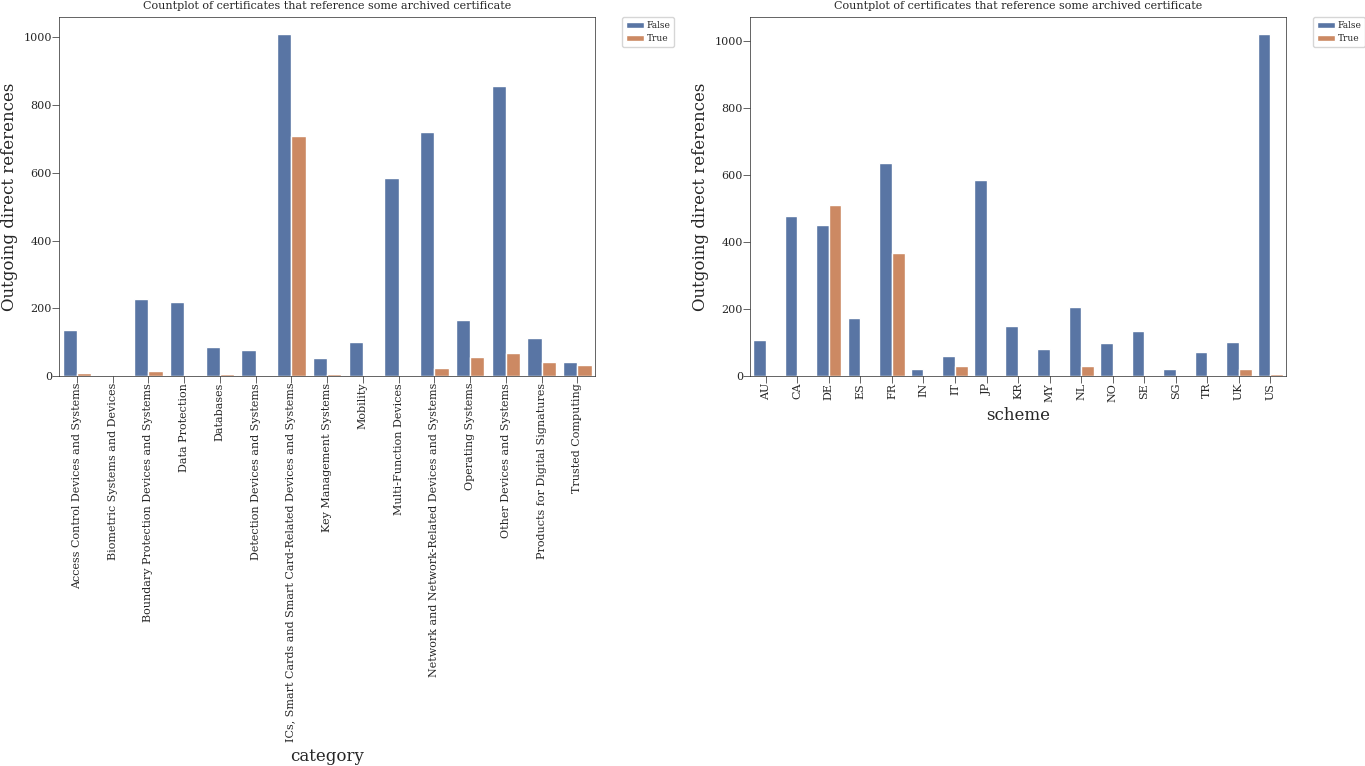

In [17]:
def references_archived_cert(references):
    if pd.isnull(references):
        return False

    return any([x in cert_ids] for x in references)


cert_ids = set(df.loc[((df.cert_id.notnull()) & (df.status == "archived")), "cert_id"].tolist())
df["references_archived_cert"] = df.directly_referenced_by.map(references_archived_cert)

# TODO: We should limit on the number of certificates that referenced an archived certificate at some point where they were active as well.
print(
    f"Number of certificates that reference some archived certificate: {df.loc[df.references_archived_cert].shape[0]}"
)

col_to_depict = ["category", "scheme"]

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(14, 8)
figure.set_tight_layout(True)

for index, col in enumerate(col_to_depict):
    countplot = sns.countplot(data=df, x=col, hue="references_archived_cert", ax=axes[index])
    countplot.set(
        xlabel=col,
        ylabel="Outgoing direct references",
        title="Countplot of certificates that reference some archived certificate",
    )
    countplot.tick_params(axis="x", rotation=90)
    countplot.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)


### Count scheme references (Sankey diagram)

AttributeError: 'LatexManager' object has no attribute 'latex'

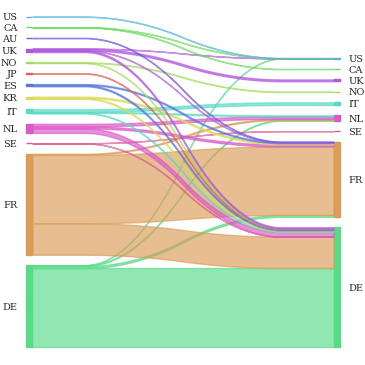

In [18]:
cert_id_to_scheme_mapping = dict(zip(df.cert_id, df.scheme))

df_ref_rich = df_id_rich.loc[df.directly_referencing.notnull()]
exploded = df_ref_rich.loc[:, ["scheme", "directly_referencing"]].explode("directly_referencing")

exploded["ref_scheme"] = exploded.directly_referencing.map(cert_id_to_scheme_mapping)
exploded = exploded.loc[exploded.ref_scheme.notnull()]

all_schemes = set(exploded.scheme.unique()) | set(exploded.ref_scheme.unique())
colors = list(sns.color_palette("hls", len(all_schemes), as_cmap=False).as_hex())
color_dict = dict(zip(all_schemes, colors))

figure, axes = plt.subplots(1, 1)
figure.set_size_inches(4, 4)
figure.set_tight_layout(True)

sankey(
    exploded.scheme,
    exploded.ref_scheme,
    colorDict=color_dict,
    leftLabels=list(exploded.scheme.unique()),
    rightLabels=list(exploded.ref_scheme.unique()),
    fontsize=7,
    ax=axes,
)

figure.savefig(str(RESULTS_DIR / "scheme_references.pdf"), bbox_inches="tight")
figure.savefig(str(RESULTS_DIR / "scheme_references.pgf"), bbox_inches="tight")
plt.show()
plt.close(figure)


## Reference network visualization

In [19]:
certs_with_ids = {cert.heuristics.cert_id: cert for cert in dset if cert.heuristics.cert_id}

print(f"Certificates in dataset: {len(dset)}")
print(f"Certificates with extracted IDs: {len(certs_with_ids)}")


Certificates in dataset: 5356
Certificates with extracted IDs: 5202


### Certificate report references

In [20]:
refs_cr = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs_cr.add_node(cert_id, cert=cert)
for cert_id, cert in certs_with_ids.items():
    if cr_refs := cert.heuristics.report_references.directly_referencing:
        for ref_id in cr_refs:
            if ref_id in certs_with_ids:
                refs_cr.add_edge(cert_id, ref_id, type=("cr",))
print(f"References in certificate reports: {len(refs_cr.edges)}")


References in certificate reports: 2393


### Security target references

In [21]:
refs_st = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs_st.add_node(cert_id, cert=cert)
for cert_id, cert in certs_with_ids.items():
    if st_refs := cert.heuristics.st_references.directly_referencing:
        for ref_id in st_refs:
            if ref_id in certs_with_ids:
                refs_st.add_edge(cert_id, ref_id, type=("st",))
print(f"References in security targets: {len(refs_st.edges)}")


References in security targets: 981


### Combined references

In [22]:
refs = nx.DiGraph()
for cert_id, cert in certs_with_ids.items():
    refs.add_node(cert_id, cert=cert)

for cert_id, cert in certs_with_ids.items():
    cr_refs = cert.heuristics.report_references.directly_referencing
    st_refs = cert.heuristics.st_references.directly_referencing
    cr_refs = set(cr_refs) if cr_refs is not None else set()
    st_refs = set(st_refs) if st_refs is not None else set()
    both = cr_refs.union(st_refs)
    for ref in both:
        if ref not in certs_with_ids:
            continue
        if ref in cr_refs and ref not in st_refs:
            refs.add_edge(cert_id, ref, type=("cr",))
        elif ref in st_refs and ref not in cr_refs:
            refs.add_edge(cert_id, ref, type=("st",))
        else:
            refs.add_edge(cert_id, ref, type=("cr", "st"))
print(f"Combined references (not double counted): {len(refs.edges)}")


Combined references (not double counted): 2644


### Certificate overview
Enter the certificate you are interested in below and see its reference graph component.

In [23]:
cert_id = "ANSSI-CC-2019/02"


In [24]:
cert = certs_with_ids.get(cert_id)
if cert is None:
    print(f"Certificate with id {cert_id} is not present in the dataset.")

for component in nx.weakly_connected_components(refs):
    if cert_id in component:
        break

view = nx.subgraph_view(refs, lambda node: node in component)
print(f"Certificate with id {cert_id}:")
print(f" - is in a component with {len(view.nodes)} certificates and {len(view.edges)} references.")
print(f" - references {list(view[cert_id].keys())}")
print(f" - is referenced by {list(view.predecessors(cert_id))}")
print(f" - its page is at https://seccerts.org/cc/{cert.dgst}/")


Certificate with id ANSSI-CC-2019/02:
 - is in a component with 21 certificates and 22 references.
 - references ['ANSSI-CC-2018/13', 'ANSSI-CC-2019/01']
 - is referenced by ['ANSSI-CC-2019/60']
 - its page is at https://seccerts.org/cc/102bbdfcd696d7a9/


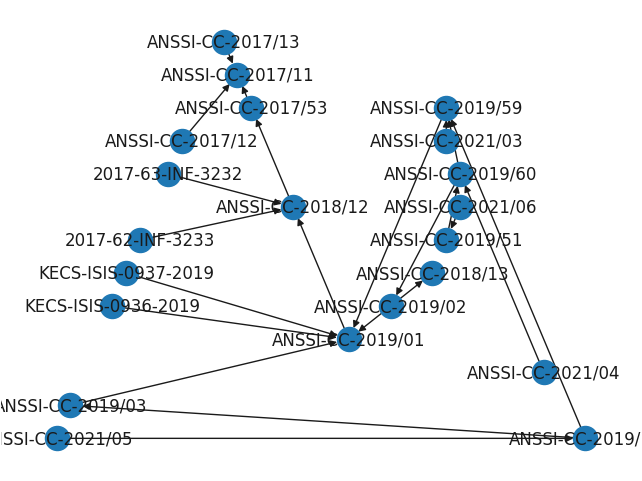

In [25]:
nx.draw(view, pos=nx.planar_layout(view), with_labels=True)


## Some graph metrics
From <https://dataground.io/2021/09/29/simple-graph-metrics-networkx-for-beginners/> and
<https://theslaps.medium.com/centrality-metrics-via-networkx-python-e13e60ba2740>.
Also good <https://www.geeksforgeeks.org/network-centrality-measures-in-a-graph-using-networkx-python/>

In [26]:
print(f"Density = {nx.density(refs)}")
print(f"Transitivity = {nx.transitivity(refs)}")


Density = 9.772467823854003e-05
Transitivity = 0.29055619930475085


In [27]:
print("Degree centrality <Popularity> (top 20):")
degree_centrality_vals = [(node, val) for node, val in nx.degree_centrality(refs).items()]
degree_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in degree_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")


Degree centrality <Popularity> (top 20):
	BSI-DSZ-CC-0555-2009 = 0.008652182272639877
	BSI-DSZ-CC-0410-2007 = 0.008652182272639877
	ANSSI-CC-2010/02 = 0.008267640838300326
	BSI-DSZ-CC-0829-2012 = 0.006152662949432801
	BSI-DSZ-CC-0837-V2-2014 = 0.005960392232263026
	BSI-DSZ-CC-0813-2012 = 0.005768121515093251
	BSI-DSZ-CC-1059-2018 = 0.005191309363583926
	BSI-DSZ-CC-0891-V2-2016 = 0.004614497212074601
	BSI-DSZ-CC-1040-2019 = 0.004422226494904826
	BSI-DSZ-CC-0782-V2-2015 = 0.004422226494904826
	BSI-DSZ-CC-0645-2010 = 0.0042299557777350505
	BSI-DSZ-CC-0266-2005 = 0.0038454143433955005
	BSI-DSZ-CC-1110-V2-2019 = 0.0036531436262257255
	BSI-DSZ-CC-0322-2005 = 0.0036531436262257255
	BSI-DSZ-CC-0973-V2-2016 = 0.0034608729090559506
	BSI-DSZ-CC-0978-2016 = 0.0034608729090559506
	ANSSI-CC-2015/36 = 0.0034608729090559506
	BSI-DSZ-CC-0782-2012 = 0.0034608729090559506
	ANSSI-CC-2011/07 = 0.0034608729090559506
	BSI-DSZ-CC-0633-2010 = 0.0032686021918861756


In [28]:
print("Eigenvector centrality <Influence> (top 20):")
eigenvector_centrality_vals = [(node, val) for node, val in nx.eigenvector_centrality(refs).items()]
eigenvector_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in eigenvector_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")


Eigenvector centrality <Influence> (top 20):
	BSI-DSZ-CC-0404-2007 = 0.3499791663317535
	BSI-DSZ-CC-0410-2007 = 0.32813666818090936
	BSI-DSZ-CC-0858-2013 = 0.3093379867591983
	BSI-DSZ-CC-0555-2009 = 0.30933783786642705
	BSI-DSZ-CC-0674-2011 = 0.2900032285711939
	BSI-DSZ-CC-0709-2010 = 0.2706698443806617
	BSI-DSZ-CC-0750-V2-2014 = 0.23200295215903557
	BSI-DSZ-CC-0633-2010 = 0.232002713129964
	BSI-DSZ-CC-0710-2010 = 0.2320025242053116
	NSCIB-CC-13-37760-CR2 = 0.17400201974056526
	BSI-DSZ-CC-0675-2011 = 0.17400191049227
	BSI-DSZ-CC-0730-2011 = 0.17400189318816653
	BSI-DSZ-CC-0913-2014 = 0.13050141989302394
	BSI-DSZ-CC-0911-2014 = 0.13050141989302394
	BSI-DSZ-CC-0912-2014 = 0.13050141989302394
	BSI-DSZ-CC-0798-2012 = 0.13050141989302394
	BSI-DSZ-CC-0797-2012 = 0.13050141989302394
	BSI-DSZ-CC-0799-2012 = 0.13050141989302394
	BSI-DSZ-CC-0914-2014 = 0.13050141989302394
	BSI-DSZ-CC-0804-2012 = 0.13050141989302394


In [29]:
print("Closeness centrality <Centralness> (top 20):")
closeness_centrality_vals = [(node, val) for node, val in nx.closeness_centrality(refs).items()]
closeness_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in closeness_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")


Closeness centrality <Centralness> (top 20):
	BSI-DSZ-CC-0782-2012 = 0.009347591315113738
	BSI-DSZ-CC-0555-2009 = 0.008892079681218678
	BSI-DSZ-CC-0410-2007 = 0.008823246660710044
	ANSSI-CC-2010/02 = 0.00824502075392741
	BSI-DSZ-CC-0758-2012 = 0.007682862668377188
	BSI-DSZ-CC-0813-2012 = 0.007430047714077973
	BSI-DSZ-CC-0728-2011 = 0.006864608765368054
	BSI-DSZ-CC-0266-2005 = 0.006540607405315179
	BSI-DSZ-CC-0404-2007 = 0.006461234002841855
	BSI-DSZ-CC-0640-2010 = 0.0060273309263888
	BSI-DSZ-CC-0837-V2-2014 = 0.005907210970067131
	BSI-DSZ-CC-0973-V2-2016 = 0.005867954387469865
	BSI-DSZ-CC-0891-V2-2016 = 0.00582055898341228
	BSI-DSZ-CC-0891-2015 = 0.005802455571730712
	ANSSI-CC-2009/26 = 0.005636395619500341
	BSI-DSZ-CC-0829-2012 = 0.0056259212971864385
	BSI-DSZ-CC-0322-2005 = 0.005590322787387868
	BSI-DSZ-CC-0973-2016 = 0.005492559434615112
	ANSSI-CC-2009/05 = 0.005405275998255349
	ANSSI-CC-2009/06 = 0.005158411332129022


In [30]:
print("Betweenness centrality <Bridge> (top 20):")
betweenness_centrality_vals = [(node, val) for node, val in nx.betweenness_centrality(refs).items()]
betweenness_centrality_vals.sort(key=lambda pair: pair[1], reverse=True)
for pair in betweenness_centrality_vals[:20]:
    print(f"\t{pair[0]} = {pair[1]}")


Betweenness centrality <Bridge> (top 20):
	ANSSI-CC-2010/02 = 1.4309378373981335e-05
	BSI-DSZ-CC-1110-V2-2019 = 1.2497596616035378e-05
	BSI-DSZ-CC-1110-2019 = 1.1055566237262065e-05
	BSI-DSZ-CC-0945-V2-2018 = 9.798411548075075e-06
	BSI-DSZ-CC-0945-V3-2018 = 9.539585582654223e-06
	BSI-DSZ-CC-0891-2015 = 8.689157410557141e-06
	BSI-DSZ-CC-0891-V2-2016 = 8.522769289929452e-06
	ANSSI-CC-2009/51 = 7.6292034569289e-06
	BSI-DSZ-CC-1110-V3-2020 = 7.542928135121944e-06
	BSI-DSZ-CC-0782-2012 = 7.542928135121944e-06
	BSI-DSZ-CC-0829-2012 = 6.211823170100425e-06
	BSI-DSZ-CC-1110-V4-2021 = 5.250469584251549e-06
	BSI-DSZ-CC-0266-2005 = 4.58491710174079e-06
	BSI-DSZ-CC-0891-V3-2018 = 3.919364619230029e-06
	BSI-DSZ-CC-0945-2017 = 3.4756629642228564e-06
	BSI-DSZ-CC-0782-V2-2015 = 2.7854603897672535e-06
	BSI-DSZ-CC-1059-2018 = 2.5143093783739813e-06
	ANSSI-CC-2014/86 = 2.4187902720877152e-06
	BSI-DSZ-CC-0973-V2-2016 = 2.403383964622188e-06
	BSI-DSZ-CC-0223-2003 = 2.403383964622188e-06


In [31]:
component_lengths = list(filter(lambda comp_len: comp_len > 1, map(len, nx.weakly_connected_components(refs))))
component_lengths.sort(reverse=True)
# print(component_lengths)
print(f"Number of weakly connected subgraphs: {len(component_lengths)}")
print(f"Size of the largest weakly connected subgraphs: {component_lengths[:10]}")


Number of weakly connected subgraphs: 206
Size of the largest weakly connected subgraphs: [1018, 45, 39, 33, 24, 23, 21, 19, 16, 15]


In [32]:
big_boy = refs.subgraph(max(nx.weakly_connected_components(refs), key=len))
communities = list(nx_comm.greedy_modularity_communities(big_boy))
print(len(communities))


25


In [33]:
for com in communities:
    for i in sorted(com):
        print(f"\t{i}")


	ANSSI-CC-2014/86
	ANSSI-CC-2015/01
	ANSSI-CC-2015/02
	ANSSI-CC-2015/03
	ANSSI-CC-2015/04
	ANSSI-CC-2015/08
	ANSSI-CC-2015/15
	ANSSI-CC-2015/30
	ANSSI-CC-2015/37
	ANSSI-CC-2015/38
	ANSSI-CC-2015/39
	ANSSI-CC-2015/40
	ANSSI-CC-2015/41
	ANSSI-CC-2015/62
	ANSSI-CC-2015/63
	ANSSI-CC-2015/64
	ANSSI-CC-2015/65
	ANSSI-CC-2015/76
	ANSSI-CC-2015/77
	ANSSI-CC-2015/78
	ANSSI-CC-2015/79
	ANSSI-CC-2016/03
	ANSSI-CC-2016/04
	ANSSI-CC-2016/17
	ANSSI-CC-2016/18
	ANSSI-CC-2016/19
	ANSSI-CC-2016/20
	ANSSI-CC-2016/21
	ANSSI-CC-2016/26
	ANSSI-CC-2016/27
	ANSSI-CC-2016/28
	ANSSI-CC-2016/29
	ANSSI-CC-2016/30
	ANSSI-CC-2016/34
	ANSSI-CC-2016/35
	ANSSI-CC-2016/36
	ANSSI-CC-2016/37
	ANSSI-CC-2016/38
	ANSSI-CC-2016/39
	ANSSI-CC-2016/40
	ANSSI-CC-2016/41
	ANSSI-CC-2016/45
	ANSSI-CC-2016/46
	ANSSI-CC-2016/47
	ANSSI-CC-2016/48
	ANSSI-CC-2016/49
	ANSSI-CC-2016/50
	ANSSI-CC-2016/51
	ANSSI-CC-2016/52
	ANSSI-CC-2016/63
	BSI-DSZ-CC-0666-2012
	BSI-DSZ-CC-0808-2013
	BSI-DSZ-CC-0808-V2-2016
	BSI-DSZ-CC-0808-V3-2017
	BSI-D

## LaTeX commands

In [34]:
# TODO: These are old commands that belonged to first paper. Replace them with code that can produce the similar numbers.
# print(f"\\newcommand{{\\numCcAllDirectReferencing}}{{{df.has_outgoing_direct_references.sum()}}}")
# print(f"\\newcommand{{\\numCcAllNotDirectReferencing}}{{{len(df) - df.has_outgoing_direct_references.sum()}}}")
# print(f"\\newcommand{{\\numCcWithIdDirectReferencing}}{{{df_id_rich.has_outgoing_direct_references.sum()}}}")
# print(f"\\newcommand{{\\numCcWithIdNotDirectReferencing}}{{{len(df_id_rich) - df_id_rich.has_outgoing_direct_references.sum()}}}")
# print(f"\\newcommand{{\\numCCActiveDirectReferencing}}{{{df_id_rich.loc[df_id_rich.status == 'active'].has_outgoing_direct_references.sum()}}}")

# print("")
# print(f"\\newcommand{{\\numCCDirectRefsSameCategory}}{{{(exploded_with_refs.category == exploded_with_refs.ref_category).sum()}}}")
# print(f"\\newcommand{{\\numCCDirectRefsOtherCategory}}{{{(exploded_with_refs.category != exploded_with_refs.ref_category).sum()}}}")
# print(f"\\newcommand{{\\numCCDirectRefs}}{{{len(exploded_with_refs)}}}")
# print(f"\\newcommand{{\\numCCDirectRefsFromSmartcards}}{{{(exploded_with_refs.category == 'ICs, Smart Cards and Smart Card-Related Devices and Systems').sum()}}}")

# print("")
# print(f"\\newcommand{{\\numCCUSReferencing}}{{{len(df_id_rich.loc[(df_id_rich.scheme == 'US') & (df_id_rich.directly_referencing.notnull())])}}}")
# print(f"\\newcommand{{\\numCCUS}}{{{len(df_id_rich.loc[(df_id_rich.scheme == 'US')])}}}")


\newcommand{\numCcAllDirectReferencing}{1553}
\newcommand{\numCcAllNotDirectReferencing}{3803}
\newcommand{\numCcWithIdDirectReferencing}{1553}
\newcommand{\numCcWithIdNotDirectReferencing}{3726}
\newcommand{\numCCActiveDirectReferencing}{526}
\newcommand{\numCCActiveDirectReferencingArchived}{175}

\newcommand{\numCCDirectRefsSameCategory}{2215}
\newcommand{\numCCDirectRefsOtherCategory}{201}
\newcommand{\numCCDirectRefs}{2416}
\newcommand{\numCCDirectRefsFromSmartcards}{1969}

\newcommand{\numCCUSReferencing}{4}
\newcommand{\numCCUS}{1010}
